In [3]:
import random
import numpy as np
import matplotlib.pyplot as plt
plt.rc('text', usetex=False)
%matplotlib inline

TRANSMITTED = 1
REFLECTED = 0
ABSORBED = 2

DOWN = 1
UP = -1

def exp_dist(x):
    return -np.log(1-x)

def draw_random_tau():
    xi = np.random.random()
    tau = exp_dist(xi)
    return tau

def change_direction(current_dir):
    if(current_dir == DOWN):
        return UP
    else:
        return DOWN

# Will return 1 if transmitted, 0 if reflected, 2 if absorbed, and -1 for issues
def track_photon(tau_bar, g_asym, absorb_wpi):
    depth = draw_random_tau()
    prob_forward = (1+g_asym)/2
    direction = DOWN
    #print("First tau is "+str(depth))
    while(depth>0 and depth<tau_bar):
        absorb_random = np.random.random()
        if(absorb_random > absorb_wpi):
            #print("Photon Absorbed!")
            return ABSORBED
        dir_random = np.random.random()
        if(dir_random > prob_forward):
            #print("Direction Changed")
            direction = change_direction(direction)
        next_tau = draw_random_tau()
        depth = depth + direction*next_tau
        #print("New depth: "+str(depth))
    if(depth>tau_bar):
        #print("Photon Transmitted!")
        return TRANSMITTED
    elif(depth<0):
        #print("Photon Reflected!")
        return REFLECTED
    else:
        return -1

In [4]:
def full_sim(num_photons, tau_bar, g_asym, absorb_wpi): 
    
    reflect_count = 0
    trans_count = 0
    absorb_count = 0
    
    #print("Starting sim for tau_bar = "+str(tau_bar)  +" and g="+str(g_asym) + " and curly pi = " + str(absorb_wpi))
    
    for i in range(num_photons):
        result = track_photon(tau_bar, g_asym, absorb_wpi)
        if(result == TRANSMITTED):
            trans_count = trans_count+1
        elif(result == REFLECTED):
            reflect_count = reflect_count+1
        elif(result == ABSORBED):
            absorb_count = absorb_count +1
        else:
            print("Error in photon tracking")
    return [reflect_count/num_photons, trans_count/num_photons, absorb_count/num_photons]

In [11]:
num_taus = 50
tb = np.linspace(1, 100, num_taus)
ref = np.zeros(num_taus)
tran = np.zeros(num_taus)
absorb = np.zeros(num_taus)

wpi = 1
g = 0.85
n_photons = 1000

for i in range(num_taus):
    results = full_sim(n_photons, tb[i], g, wpi)
    ref[i] = results[0]
    tran[i] = results[1]
    absorb[i] = results[2]

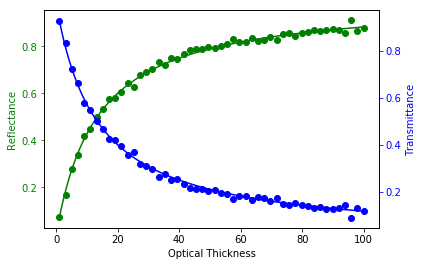

In [12]:
t_range = np.linspace(1,100, 1000)
fig, ax1 = plt.subplots()
ax1.plot(tb, ref, 'og', label="Reflected")
ax1.plot(t_range, t_range/(2/(1-g)+t_range), "-g")
ax1.set_ylabel('Reflectance', color='g')
ax1.tick_params('y', colors='g')

ax1.set_xlabel("Optical Thickness")

ax2 = ax1.twinx()
ax2.plot(tb, tran, 'ob', label="Transmitted")
ax2.plot(t_range, 1/((1-g)*t_range/2+1), "-b", label="Transmitted True")
ax2.set_ylabel('Transmittance', color='b')
ax2.tick_params('y', colors='b')

## Using Absorbtion

Using true solutions:
\begin{align*}
\text{Transmitted} = F_\downarrow (\bar{\tau}) = \bar{A} R_\infty e^{K\bar{\tau}} + \bar{B} e^{-K\bar{\tau}} \\\\
\text{Reflected from Below} = F_\uparrow (\tau=0) = \bar{A} + \bar{B}  R_\infty \\\\
R_\infty = \frac{\sqrt{1-\varpi g}-\sqrt{1-\varpi}}{\sqrt{1-\varpi g}+\sqrt{1-\varpi}} \\\\
K = \sqrt{(1-\varpi g)(1-\varpi)}
\end{align*}
With the following defined:
\begin{align*}
\bar{A} = \frac{F_0 ( R_\infty - R_g ) e^{-K\bar{\tau}}}{R_\infty ( R_\infty-R_g ) e^{-K\bar{\tau}} - ( 1 - R_g R_\infty) e^{K\bar{\tau}}} \\\\
\bar{B} = \frac{-F_0 ( 1 - R_g R_\infty ) e^{K\bar{\tau}}}{R_\infty ( R_\infty-R_g ) e^{-K\bar{\tau}} - ( 1 - R_g R_\infty) e^{K\bar{\tau}}} \\\\\
R_g = \text{Albedo of Surface below the layer}  = 0
\end{align*}

In [5]:
#Run the simulation
num_taus = 100
tb = np.linspace(1, 100, num_taus)
ref = np.zeros(num_taus)
tran = np.zeros(num_taus)
absorb = np.zeros(num_taus)

wpi = 0.9
g = 0.85
n_photons = 1000

for i in range(num_taus):
    results = full_sim(n_photons, tb[i], g, wpi)
    ref[i] = results[0]
    tran[i] = results[1]
    absorb[i] = results[2]

In [6]:
R_g = 0
R_inf = (np.sqrt(1-wpi*g)-np.sqrt(1-wpi))/(np.sqrt(1-wpi*g)+np.sqrt(1-wpi))
K = np.sqrt((1-wpi*g)*(1-wpi))
A_numerator = (R_inf-R_g)*np.exp(-K*tb)
B_numerator = -(1-R_inf*R_g)*np.exp(K*tb)
denominator = R_inf*(R_inf-R_g)*np.exp(-K*tb) - (1 - R_inf*R_g)*np.exp(K*tb)
A_bar = np.divide(A_numerator, denominator)
B_bar = np.divide(B_numerator, denominator)
T_true = np.multiply(A_bar, R_inf*np.exp(K*tb))+ np.multiply(B_bar, np.exp(-K*tb))
R_true = A_bar+B_bar*R_inf

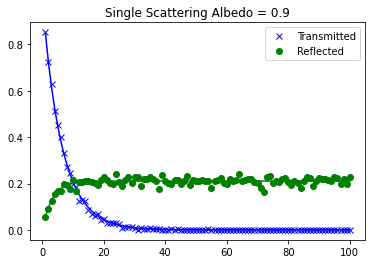

In [7]:
plt.plot(tb, T_true, 'b-')
plt.plot(tb, tran, 'bx', label="Transmitted")
plt.plot(tb, R_true, 'g-')
plt.plot(tb, ref, 'go', label="Reflected")
plt.title("Single Scattering Albedo = 0.9")
plt.legend()